In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import json
import pathlib
import numpy as np
import pandas as pd
import html
import re
from fastai.text import *

In [4]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

LANG = 'id'
PATH_ROOT = Path(f'lmdata/{LANG}')
PATH_DATASET = Path(f'{PATH_ROOT}/dataset/BPPTIndToEngCorpus')
PATH_MODELS = Path(f'{PATH_ROOT}/models/')
PATH_TMP = Path(f'{PATH_ROOT}/tmp/')
np.random.seed(42)

In [5]:
LANG_FILENAMES = [str(f) for f in PATH_DATASET.rglob("*-ID-*.txt")]
print(len(LANG_FILENAMES))
LANG_FILENAMES

4


['lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-ECO-ID-150Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-INT-ID-150Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-SCI-ID-100Kw.txt',
 'lmdata/id/dataset/BPPTIndToEngCorpus/PANL-BPPT-SPO-ID-100Kw.txt']

In [6]:
CLASSES = {v:i for i,v in enumerate(['ECO', 'INT', 'SCI', 'SPO'])}
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    CLASSNAME = re.sub('.+-([A-Z]+)-ID.+', r'\1', fn)
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append((CLASSES[CLASSNAME], line.rstrip()))

df = pd.DataFrame.from_records(LANG_TEXT, columns=['label', 'text'])
df.head()

100%|██████████| 4/4 [00:00<00:00, 231.62it/s]


,label,text
0,0,Menteri Keuangan Sri Mulyani mengatakan koreks...
1,0,Dalam jumpa pers bersama Dirut Bursa Efek Jaka...
2,0,Kita melihat faktor inflasi dari makanan akan ...
3,0,Demikian pula dengan harga minyak.
4,0,"Kondisi APBN 2007 pada dua pekan awal, secara ..."


In [6]:
df.to_csv(f"{PATH_DATASET}/bppt_panl.csv", header=False, index=False)

In [7]:
df = pd.read_csv(f"{PATH_DATASET}/bppt_panl.csv")
df.columns = ['label', 'text']

In [8]:
df.head()

,label,text
0,0,Dalam jumpa pers bersama Dirut Bursa Efek Jaka...
1,0,Kita melihat faktor inflasi dari makanan akan ...
2,0,Demikian pula dengan harga minyak.
3,0,"Kondisi APBN 2007 pada dua pekan awal, secara ..."
4,0,"Menurut data Depkeu, net buy obligasi negara a..."


In [9]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(
    df, test_size=0.1, random_state=1) # split the data into train and validation sets

In [10]:
trn_texts[:5]

,label,text
12489,1,"Saya berada di sini dua tahun lalu, tapi saat ..."
1604,0,Pertumbuhan ekonomi 2007 yang diproyeksikan me...
19548,3,Pelatih Real Bernd Schuster harus mengeluarkan...
15680,2,Laporan itu adalah pengumuman kedua dari badan...
2780,0,"Lonjakan laba bersih tersebut, selain didorong..."


In [11]:
trn_texts.to_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=False, index=False)
val_texts.to_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=False, index=False)

In [11]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [12]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [13]:
chunksize = 10000
df_trn = pd.read_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=None, chunksize=chunksize)

In [15]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [16]:
tok_trn[:2]

[['\n',
  'xbos',
  'xfld',
  '1',
  'saya',
  'berada',
  'di',
  'sini',
  'dua',
  'tahun',
  'lalu',
  ',',
  'tapi',
  'saat',
  'ini',
  'terdapat',
  'lebih',
  'banyak',
  'makanan',
  'gratis',
  'dan',
  'tak',
  'ada',
  'keributan',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'pertumbuhan',
  'ekonomi',
  '2007',
  'yang',
  'diproyeksikan',
  'mencapai',
  '6,3',
  'persen',
  ',',
  'merupakan',
  'tantangan',
  'berat',
  'meski',
  'sampai',
  'dengan',
  'hari',
  'ini',
  'hampir',
  'semua',
  'kalangan',
  'berpendapat',
  'realitas',
  'pertumbuhan',
  'realitas',
  'mencapai',
  'sekitar',
  '6,1',
  'persen',
  '.']]

In [17]:
# create a tmp directory to store the upcoming numpy arrays
(PATH_TMP).mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(PATH_TMP/'tok_trn.npy', tok_trn)
np.save(PATH_TMP/'tok_val.npy', tok_val)

In [14]:
tok_trn = np.load(PATH_ROOT/'tmp'/'tok_trn.npy')
tok_val = np.load(PATH_ROOT/'tmp'/'tok_val.npy')

In [15]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 26503),
 ('1', 22182),
 ('.', 21637),
 ('\n', 21620),
 ('xbos', 21620),
 ('xfld', 21620),
 ('yang', 12838),
 ('dan', 9496),
 ('di', 8706),
 ('-', 6737),
 ('pada', 5305),
 ('dari', 4999),
 ('dengan', 4884),
 ('itu', 4723),
 ('t_up', 4719),
 ('untuk', 4610),
 ('dalam', 4373),
 ('ini', 3800),
 ('akan', 3147),
 ('tersebut', 2374),
 ('tidak', 2352),
 ('mereka', 2182),
 ('kata', 2153),
 ('persen', 2151),
 ('tahun', 2077)]

In [16]:
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') #

In [17]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6813

In [18]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [19]:
trn_lm[:2]

array([list([5, 6, 7, 3, 45, 142, 10, 737, 52, 26, 60, 2, 248, 55, 19, 605, 33, 124, 673, 2907, 9, 116, 67, 0, 4]),
       list([5, 6, 7, 3, 148, 98, 71, 8, 4113, 70, 1455, 25, 2, 78, 1952, 481, 389, 181, 14, 88, 19, 476, 196, 883, 2795, 0, 148, 0, 70, 105, 3029, 25, 4])],
      dtype=object)

In [20]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(PATH_TMP/'trn_ids.npy', trn_lm)
np.save(PATH_TMP/'val_ids.npy', val_lm)
pickle.dump(itos, open(PATH_MODELS/'bppt_panl_itos.pkl', 'wb'))

In [21]:
trn_lm = np.load(PATH_TMP/'trn_ids.npy')
val_lm = np.load(PATH_TMP/'val_ids.npy')
itos = pickle.load(open(PATH_MODELS/'bppt_panl_itos.pkl', 'rb'))

In [22]:
vs=len(itos)
vs,len(trn_lm)

(6813, 21620)

In [23]:
em_sz,nh,nl = 400,1150,3

In [24]:
PRE_LM_PATH = PATH_MODELS/'wiki_id_lm.h5'

In [25]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [26]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [27]:
itos2 = pickle.load((PATH_ROOT/'wiki_id_itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [28]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [29]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [30]:
wd=1e-7
bptt=70
bs=100
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.1

In [31]:
bs=100

In [32]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH_MODELS, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [33]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*weight_factor

In [34]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [35]:
learner.model.load_state_dict(wgts)

In [36]:
# AWD-LSTM network
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(6813, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(6813, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=6813)
    (dropout): LockedDropout(
    )
  )
)>

In [37]:
lr=1e-3
lrs = lr

In [38]:
%time 

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      4.572744   4.530464   0.249586  



[array([4.53046]), 0.24958564341068268]

In [39]:
learner.save('lm_last_ft')

In [40]:
learner.load('lm_last_ft')

In [41]:
learner.unfreeze()

In [31]:
%time

learner.lr_find2(num_it=1000)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs


HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

 76%|███████▋  | 65/85 [00:17<00:05,  3.72it/s, loss=3.53]

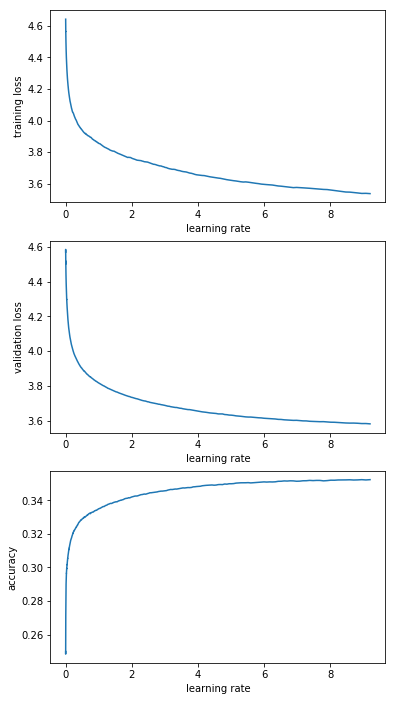

In [32]:
learner.sched.plot()

In [42]:
# Set learning rate
lr = 0.2

In [43]:
%time

learner.fit(lr, 1, wds=wd, cycle_len=50, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_indonesia_1cycle_bppt_panl')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      4.135367   3.944285   0.326097  
    1      3.935986   3.837739   0.33447                  
    2      3.843876   3.781846   0.33898                  
    3      3.785678   3.741419   0.342077                 
    4      3.747466   3.719687   0.344313                 
    5      3.709458   3.695192   0.346929                 
    6      3.679353   3.677335   0.348083                 
    7      3.652387   3.650419   0.350728                 
    8      3.630598   3.635997   0.351886                 
    9      3.610431   3.6258     0.353118                 
    10     3.589905   3.622754   0.352572                 
    11     3.569198   3.601135   0.355118                 
    12     3.552661   3.601114   0.354705                 
    13     3.536138   3.593281   0.355675                 
    14     3.521222   3.583805   0.356168                 
    15     3.504945   3.572435   0.3581                   
    16     3

[array([3.4766]), 0.36589888483285904]

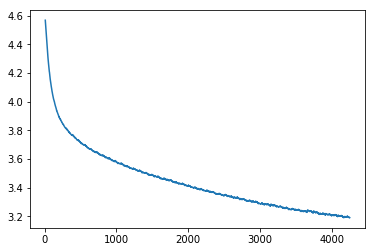

In [44]:
learner.sched.plot_loss()

In [ ]:
#learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
#learner.sched.plot()

In [ ]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

In [45]:
learner.save('lm1')
learner.save_encoder('lm1_enc')

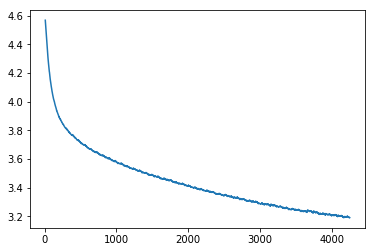

In [46]:
learner.sched.plot_loss()

## Classifier tokens


In [47]:
chunksize = 10000
df_trn = pd.read_csv(f"{PATH_DATASET}/bppt_panl_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"{PATH_DATASET}/bppt_panl_test.csv", header=None, chunksize=chunksize)

In [48]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [49]:
(PATH_TMP).mkdir(exist_ok=True)

np.save(PATH_TMP/'bppt_panl_tok_trn.npy', tok_trn)
np.save(PATH_TMP/'bppt_panl_tok_val.npy', tok_val)

np.save(PATH_TMP/'bppt_panl_trn_labels.npy', trn_labels)
np.save(PATH_TMP/'bppt_panl_val_labels.npy', val_labels)

In [50]:
tok_trn = np.load(PATH_TMP/'bppt_panl_tok_trn.npy')
tok_val = np.load(PATH_TMP/'bppt_panl_tok_val.npy')

In [51]:
itos = pickle.load((PATH_MODELS/'bppt_panl_itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6813

In [52]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [53]:
np.save(PATH_TMP/'bppt_panl_trn_ids.npy', trn_clas)
np.save(PATH_TMP/'bppt_panl_val_ids.npy', val_clas)

## Classifier

In [54]:
trn_clas = np.load(PATH_TMP/'bppt_panl_trn_ids.npy')
val_clas = np.load(PATH_TMP/'bppt_panl_val_ids.npy')

In [55]:
trn_labels = np.squeeze(np.load(PATH_TMP/'bppt_panl_trn_labels.npy'))
val_labels = np.squeeze(np.load(PATH_TMP/'bppt_panl_val_labels.npy'))

In [56]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48
weight_factor = 0.7

In [57]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [58]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH_MODELS, trn_dl, val_dl)

In [59]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [60]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*weight_factor

In [61]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [62]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [63]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [64]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [65]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [66]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [67]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 721/901 [00:13<00:03, 52.88it/s, loss=1.75] 

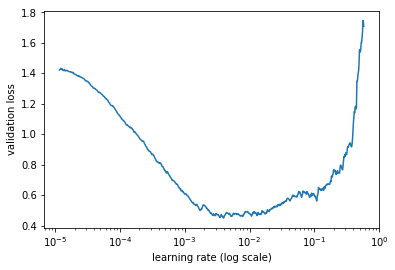

In [68]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [69]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 39%|███▊      | 348/901 [00:05<00:09, 58.58it/s, loss=0.428]

Exception in thread Thread-112:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.407182   0.214054   0.9201    



[array([0.21405]), 0.920099874783991]

In [70]:
learn.save('clas_0')

In [71]:
learn.load('clas_0')

In [72]:
learn.freeze_to(-2)

In [73]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.302196   0.195706   0.93092   



[array([0.19571]), 0.9309196849440814]

In [74]:
learn.save('clas_1')

In [75]:
learn.load('clas_1')

In [76]:
learn.unfreeze()

In [77]:
%time

learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(32,10))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.324143   0.190244   0.934665  
    1      0.283677   0.214607   0.933417                    
    2      0.288074   0.170306   0.942156                    
    3      0.196818   0.179235   0.947149                    
    4      0.192405   0.175576   0.943404                    
    5      0.177235   0.169433   0.94923                     
    6      0.174401   0.179632   0.950062                    
    7      0.162026   0.162931   0.951311                    
    8      0.12247    0.180204   0.952975                    
    9      0.110696   0.185809   0.952975                     
    10     0.114016   0.202229   0.955888                     
    11     0.080526   0.198814   0.956721                     
    12     0.108284   0.207166   0.951311                     
    13     0.130394   0.202514   0.953392                     
    14     0.085519   0.207719   0.95464                      
    15     0.074378 

[array([0.21618]), 0.9571369137805649]

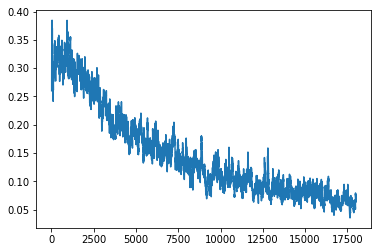

In [78]:
learn.sched.plot_loss()

In [79]:
learn.save('clas_2')

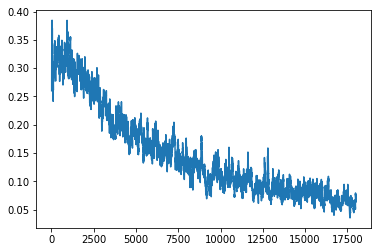

In [80]:
learn.sched.plot_loss()